<a href="https://colab.research.google.com/github/JahnaviRamagiri/END2.0/blob/main/session_5/Sentiment_Analysis_using_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 TorchText

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [ ]:
!pip install pytreebank

In [ ]:
import pytreebank
import sys
import os

out_path = 'sst_{}.txt'
dataset = pytreebank.load_sst()

# Store train, dev and test in separate files
for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))
# Print the length of the training set
print(len(dataset['train']))

8544


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/ai/data/

[Errno 2] No such file or directory: 'drive/MyDrive/ai/data/'
/content/drive/MyDrive/ai/data


In [ ]:
df = pd.read_csv('./sst_train.txt', sep='\t', header=None, names=['labels', 'sentence'])

In [ ]:
label_map = {'__label__4': 3, 
             '__label__5': 4,
             '__label__3': 2,
             '__label__2': 1,
             '__label__1': 0}

In [ ]:
df['labels'] = df['labels'].map(label_map)

In [ ]:
df['labels'].value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
Name: labels, dtype: int64

In [ ]:
dict_label = {}
for label in [4,0]:
  for a in df[df['labels'] == label]['sentence'].values[:50]:
    dict_label[google_translate(a)] = label
    dict_label.update({i:label for i in ocr_aug(a)})
    dict_label.update({i:label for i in keyward_aug(a)})

  df_extra = pd.DataFrame(dict_label.items())
  df_extra.columns = ['sentence', 'labels']
  df = pd.concat([df_extra, df])
  dict_label = {}
  print(df_extra.shape)

(448, 2)
(447, 2)


In [ ]:
df.head()

,sentence,labels
0,... a small movie in its core; Explore the con...,0
1,.. . a sour little muvie at it8 core; an explo...,0
2,.. . a 8our little movie at it8 core; an explo...,0
3,.. . a sour 1ittle movie at its core; an explo...,0
4,.. . a sour little movie at its c0re; an exp1o...,0


In [ ]:
df['labels'].value_counts()

3    2322
1    2218
2    1624
4    1288
0    1092
Name: labels, dtype: int64

In [ ]:
import seaborn as sns

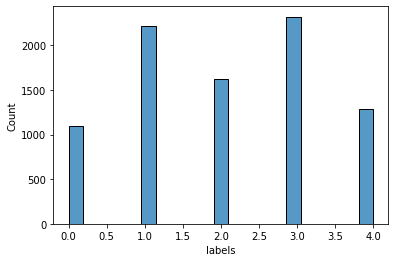

In [ ]:
sns.histplot(x='labels', data=df)

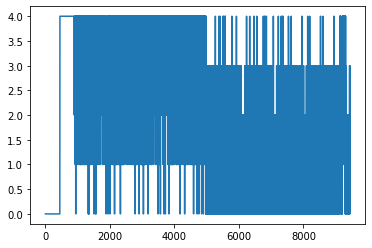

In [ ]:
df['labels'].plot()

In [ ]:
df_test = pd.read_csv('./sst_test.txt', sep='\t', header=None, names=['labels', 'sentences'])

In [ ]:
df_test['labels'] = df_test['labels'].map(label_map)

In [ ]:
df_test.head()

,labels,sentences
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


In [ ]:
df_test.shape

(2210, 2)

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [ ]:
# Import Library
import random
import torch, torchtext
from torchtext.legacy import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [ ]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [ ]:
fields = [('tweets', Tweet),('labels',Label)]

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [ ]:
df.head()

,labels,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


In [ ]:
df_test.head()

,labels,sentences
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


In [ ]:
df = df.reset_index()
df_test = df_test.reset_index()

In [ ]:
example_train = [data.Example.fromlist([df.sentence[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [ ]:
df.sentence[0]

"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."

In [ ]:
example_test = [data.Example.fromlist([df_test.sentences[i], df_test.labels[i]], fields) for i in range(df_test.shape[0])]

In [ ]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

valid = data.Dataset(example_test, fields)
train = data.Dataset(example_train, fields)

Finally, we can split into training, testing, and validation sets by using the split() method:

In [ ]:
(len(train), len(valid))

(8544, 2210)

An example from the dataset:

In [ ]:
vars(train.examples[1])

{'labels': 4,
 'tweets': ['The',
  'gorgeously',
  'elaborate',
  'continuation',
  'of',
  '`',
  '`',
  'The',
  'Lord',
  'of',
  'the',
  'Rings',
  "''",
  'trilogy',
  'is',
  'so',
  'huge',
  'that',
  'a',
  'column',
  'of',
  'words',
  'can',
  'not',
  'adequately',
  'describe',
  'co',
  '-',
  'writer',
  '/',
  'director',
  'Peter',
  'Jackson',
  "'s",
  'expanded',
  'vision',
  'of',
  'J.R.R.',
  'Tolkien',
  "'s",
  'Middle',
  '-',
  'earth',
  '.']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [ ]:
Tweet.build_vocab(train)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [ ]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  17165
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 8041), (',', 7131), ('the', 6087), ('and', 4474), ('of', 4446), ('a', 4423), ('to', 3024), ('-', 2739), ("'s", 2544), ('is', 2540)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(17165, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,391,605 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')
train_li = []
test_li = []

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    train_li.append(train_acc*100)
    test_li.append(valid_acc*100)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.571 | Train Acc: 28.90%
	 Val. Loss: 1.558 |  Val. Acc: 32.14% 

	Train Loss: 1.513 | Train Acc: 37.55%
	 Val. Loss: 1.560 |  Val. Acc: 32.95% 

	Train Loss: 1.415 | Train Acc: 48.50%
	 Val. Loss: 1.543 |  Val. Acc: 33.62% 

	Train Loss: 1.317 | Train Acc: 59.33%
	 Val. Loss: 1.544 |  Val. Acc: 32.63% 

	Train Loss: 1.228 | Train Acc: 68.32%
	 Val. Loss: 1.536 |  Val. Acc: 35.27% 

	Train Loss: 1.158 | Train Acc: 75.71%
	 Val. Loss: 1.540 |  Val. Acc: 34.64% 

	Train Loss: 1.099 | Train Acc: 81.67%
	 Val. Loss: 1.559 |  Val. Acc: 32.01% 

	Train Loss: 1.061 | Train Acc: 85.14%
	 Val. Loss: 1.549 |  Val. Acc: 33.75% 

	Train Loss: 1.035 | Train Acc: 87.45%
	 Val. Loss: 1.552 |  Val. Acc: 33.39% 

	Train Loss: 1.017 | Train Acc: 89.10%
	 Val. Loss: 1.554 |  Val. Acc: 33.30% 



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

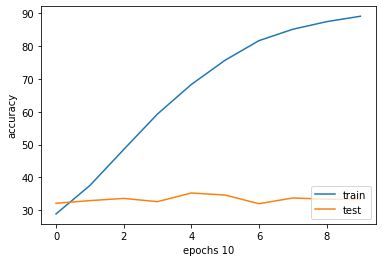

In [ ]:
plt.plot(range(0,10), train_li)
plt.xlabel('epochs 10')
plt.ylabel('accuracy')
plt.plot(range(0,10), test_li)
plt.legend(["train", "test"], loc ="lower right")

## Model Testing

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Very negative", 1:"negative", 2:"Neutral",
                  3 : 'positive', 4:'very positive'}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
for a in df_test.sentences[:10]:
  print('Text: ', a, 'Prediction: ',classify_tweet(a))

Text:  Effective but too-tepid biopic Prediction:  negative
Text:  If you sometimes like to go to the movies to have fun , Wasabi is a good place to start . Prediction:  Neutral
Text:  Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one . Prediction:  negative
Text:  The film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game . Prediction:  Very negative
Text:  Offers that rare combination of entertainment and education . Prediction:  Very negative
Text:  Perhaps no picture ever made has more literally showed that the road to hell is paved with good intentions . Prediction:  Neutral
Text:  Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it . Prediction:  negative
Text:  But he somehow pulls it off . Prediction:  negative
Text:  Take Care of My Cat offers a refreshingly different slice of Asian cinema . Pr

In [ ]:
df_test.sentences[50]

"An engaging overview of Johnson 's eccentric career ."

## Discussion on Data Augmentation Techniques 

You might wonder exactly how you can augment text data. After all, you can’t really flip it horizontally as you can an image! :D 

In contrast to data augmentation in images, augmentation techniques on data is very specific to final product you are building. As its general usage on any type of textual data doesn't provides a significant performance boost, that's why unlike torchvision, torchtext doesn’t offer a augmentation pipeline. Due to powerful models as transformers, augmentation tecnhiques are not so preferred now-a-days. But its better to know about some techniques with text that will provide your model with a little more information for training. 

### Synonym Replacement

First, you could replace words in the sentence with synonyms, like so:

    The dog slept on the mat

could become

    The dog slept on the rug

Aside from the dog's insistence that a rug is much softer than a mat, the meaning of the sentence hasn’t changed. But mat and rug will be mapped to different indices in the vocabulary, so the model will learn that the two sentences map to the same label, and hopefully that there’s a connection between those two words, as everything else in the sentences is the same.

### Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.), shown, but not implemented, in this function via get_synonyms() and get_stopwords(), an implementation of this would be as follows:


### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

### Back Translation

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [ ]:
!pip install -q google-trans-new
!pip install -q googletrans

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 1.0MB 17.9MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 


In [ ]:
import random
import googletrans
from google_trans_new import google_translator

translator = google_translator()
sentence = ['raghav is a good boy']
def google_translate(sentence):
  available_langs = list(googletrans.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  # print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

  translations = translator.translate(sentence, lang_tgt=trans_lang)
  # print(translations) 
  # t_text = [t.text for t in translations]
  # print(t_text)

  translations_en_random = translator.translate(translations, lang_src=trans_lang, 
                                                lang_tgt='en') 
  # en_text = [t.text for t in translations_en_random]
  # print(translations_en_random)
  return translations_en_random

In [ ]:
for a in df['sentence'].values[:10]:
  print(google_translate(a))

The 21st-century new rock is prescribed, and Anold Schwarsnier, Jean-Claude Van Dumme or Stephen Van Dumme or Stephen Van Damme or Stephen Shreg is a much greater speeds. 
The continued sound continues continued by the ring '' trilogy so a written vision of J.R.R.R.R.R.R.R.R.R.R.R.R.R. Tolkien's mid-world. 
Effective but to-tpid biper 
If you sometimes like to go to the movies to have fun, wasabi a good place to start. 
It is revealed as something rare, a film so honest, observed that it does not feel like one. 
The film provides some great insight in the neurotic mentality of all comics - which has reached the perfect top of the game. 
Gives rare combination of entertainment and education. 
Dupletions turn on the screen mirror that curls at the edge; It's so smart you want to hate it. 
But he joins it somehow. 
It is a good idea to see, speak, speak, speak and sing. 


In [ ]:
!pip install nlpaug

     |████████████████████████████████| 399kB 8.4MB/s 


In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

In [ ]:
def keyward_aug(text,n=4):
  aug = nac.KeyboardAug()
  augmented_text = aug.augment(text, n=n)
  return augmented_text

In [ ]:
def ocr_aug(text, n=4):
  aug = nac.OcrAug()
  augmented_texts = aug.augment(text, n=n)
  return augmented_texts

In [ ]:
ocr_aug('my name is raghav')

['my name is kaghav',
 'my name is raghav',
 'my name i8 raghav',
 'my name i8 raghav']